## Phase 1: Dataset Preparation

### Download and merge both datasets to get all five categories.

In [3]:
import pandas as pd
import os

In [5]:
# Define the folder path where your CSV files are stored
folder_path = r'./datasets/URL/'

# Create a dictionary to map file names (without extension) to types
file_to_type = {
    'Benign_list_big_final': 'benign',
    'DefacementSitesURLFiltered': 'defacement',
    'Malware_dataset': 'malware',
    'phishing_dataset': 'phishing',
    'spam_dataset': 'spam'
}

# Get the list of CSV files in the folder
files_in_folder = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Empty list to store DataFrames
dfs = []

# Loop through the files in the folder
for file in files_in_folder:
    # Remove the extension and get the file name without it
    file_name = os.path.splitext(file)[0]
    
    # Check if the file name exists in the dictionary
    if file_name in file_to_type:
        # Read the CSV into a DataFrame (assuming one column with URLs)
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path, header=None)  # No header, as the file only has URLs
        
        # Rename the column to 'url' since it contains the URLs
        df.columns = ['url']
        
        # Add the 'type' column based on the file name
        df['type'] = file_to_type[file_name]
        
        # Append this DataFrame to the list
        dfs.append(df)
    else:
        print(f"Warning: {file_name} not found in the dictionary.")

# Concatenate all dataframes into one
final_df = pd.concat(dfs, ignore_index=True)

final_df

,url,type
0,http://1337x.to/torrent/1048648/American-Snipe...,benign
1,http://1337x.to/torrent/1110018/Blackhat-2015-...,benign
2,http://1337x.to/torrent/1122940/Blackhat-2015-...,benign
3,http://1337x.to/torrent/1124395/Fast-and-Furio...,benign
4,http://1337x.to/torrent/1145504/Avengers-Age-o...,benign
...,...,...
165361,http://archive.salisburyjournal.co.uk/2001/3/7/,spam
165362,http://astore.amazon.co.uk/allezvinsfrenchr/de...,spam
165363,http://archive.thisischeshire.co.uk/2000/1/14/...,spam
165364,http://applerugs.co.uk/rugs/product_info.php?p...,spam


In [7]:
# Now, read the malicious_phish.csv dataset
malicious_df = pd.read_csv(r".\datasets\malicious_phish.csv")

# Concatenate malicious_df with final_df (merge both DataFrames)
final_df = pd.concat([final_df, malicious_df], ignore_index=True)

final_df

,url,type
0,http://1337x.to/torrent/1048648/American-Snipe...,benign
1,http://1337x.to/torrent/1110018/Blackhat-2015-...,benign
2,http://1337x.to/torrent/1122940/Blackhat-2015-...,benign
3,http://1337x.to/torrent/1124395/Fast-and-Furio...,benign
4,http://1337x.to/torrent/1145504/Avengers-Age-o...,benign
...,...,...
816552,xbox360.ign.com/objects/850/850402.html,phishing
816553,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
816554,www.gamespot.com/xbox360/action/deadspace/,phishing
816555,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [8]:
# Save the combined DataFrame to a CSV
final_df.to_csv('./datasets/merged_dataset.csv', index=False)

In [9]:
merged_df = pd.read_csv(r".\datasets\merged_dataset.csv")
merged_df

,url,type
0,http://1337x.to/torrent/1048648/American-Snipe...,benign
1,http://1337x.to/torrent/1110018/Blackhat-2015-...,benign
2,http://1337x.to/torrent/1122940/Blackhat-2015-...,benign
3,http://1337x.to/torrent/1124395/Fast-and-Furio...,benign
4,http://1337x.to/torrent/1145504/Avengers-Age-o...,benign
...,...,...
816552,xbox360.ign.com/objects/850/850402.html,phishing
816553,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
816554,www.gamespot.com/xbox360/action/deadspace/,phishing
816555,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [10]:
import urllib.parse
import tldextract
import numpy as np
import re
from collections import Counter
from scipy.stats import entropy

def extract_features(url):
    parsed_url = urllib.parse.urlparse(url)
    ext = tldextract.extract(url)

    domain = ext.domain + "." + ext.suffix if ext.suffix else ext.domain
    path = parsed_url.path
    query = parsed_url.query

    # Length-Based Features
    url_length = len(url)
    domain_length = len(domain)
    path_length = len(path)
    subdir_length = len(parsed_url.path.rsplit('/', 1)[0]) if '/' in parsed_url.path else 0
    filename_length = len(parsed_url.path.split('/')[-1])
    file_extension_length = len(parsed_url.path.split('.')[-1]) if '.' in parsed_url.path else 0
    arg_length = len(query)

    # Token-Based Features
    domain_tokens = domain.split('.')
    path_tokens = path.split('/')
    query_tokens = query.split('&')

    avg_domain_token_len = np.mean([len(token) for token in domain_tokens]) if domain_tokens else 0
    long_domain_token_len = max([len(token) for token in domain_tokens], default=0)
    avg_path_token_len = np.mean([len(token) for token in path_tokens]) if path_tokens else 0

    # Character-Based Features
    digit_count = sum(c.isdigit() for c in url)
    letter_count = sum(c.isalpha() for c in url)
    special_char_count = sum(not c.isalnum() for c in url)

    # Entropy Features
    def calc_entropy(text):
        if not text:
            return 0
        text_count = Counter(text)
        probs = [text_count[c] / len(text) for c in text_count]
        return entropy(probs, base=2)

    url_entropy = calc_entropy(url)
    entropy_domain = calc_entropy(domain)
    entropy_path = calc_entropy(path)
    entropy_query = calc_entropy(query)

    # Obfuscation Features
    is_ip = bool(re.match(r"^(?:[0-9]{1,3}\.){3}[0-9]{1,3}$", domain))
    dot_count = url.count(".")
    
    # Ratio-Based Features
    path_url_ratio = path_length / url_length if url_length else 0
    arg_url_ratio = arg_length / url_length if url_length else 0
    domain_url_ratio = domain_length / url_length if url_length else 0
    path_domain_ratio = path_length / domain_length if domain_length else 0
    arg_path_ratio = arg_length / path_length if path_length else 0  # FIXED THIS

    # Threat Indicators
    sensitive_keywords = ['login', 'bank', 'secure', 'account', 'update', 'verify']
    url_sensitive_word = any(word in url.lower() for word in sensitive_keywords)

    # Executable Indicators
    executable = 1 if url.endswith(('.exe', '.zip', '.rar', '.tar', '.gz')) else 0

    # Number of symbols
    delimiter_count = url.count('.') + url.count('/') + url.count('?') + url.count('=') + url.count('&')

    # Max Token Lengths
    max_path_token_len = max(len(token) for token in path_tokens) if path_tokens else 0
    max_domain_token_len = max(len(token) for token in domain_tokens) if domain_tokens else 0
    max_query_token_len = max(len(token) for token in query_tokens) if query_tokens else 0

    # Additional Features to Make Exactly 79
    number_rate_url = digit_count / url_length if url_length else 0
    number_rate_domain = digit_count / domain_length if domain_length else 0
    number_rate_path = digit_count / path_length if path_length else 0
    number_rate_filename = digit_count / filename_length if filename_length else 0
    number_rate_extension = digit_count / file_extension_length if file_extension_length else 0
    number_rate_query = digit_count / arg_length if arg_length else 0
    
    special_domain_count = sum(c in '.-' for c in domain)
    special_path_count = sum(c in '.-' for c in path)
    special_filename_count = sum(c in '.-' for c in parsed_url.path.split('/')[-1])
    special_extension_count = sum(c in '.-' for c in parsed_url.path.split('.')[-1]) if '.' in parsed_url.path else 0
    special_query_count = sum(c in '.-' for c in query)

    feature_vector = [
        url_length, domain_length, path_length, subdir_length, filename_length, file_extension_length, arg_length,
        len(domain_tokens), len(path_tokens), avg_domain_token_len, long_domain_token_len, avg_path_token_len,
        digit_count, letter_count, special_char_count,
        url_entropy, entropy_domain, entropy_path, entropy_query,
        is_ip, dot_count, delimiter_count, path_url_ratio, arg_url_ratio, domain_url_ratio, path_domain_ratio, arg_path_ratio,
        max_path_token_len, max_domain_token_len, max_query_token_len,
        url_sensitive_word, executable,
        number_rate_url, number_rate_domain, number_rate_path, number_rate_filename, number_rate_extension, number_rate_query,
        special_domain_count, special_path_count, special_filename_count, special_extension_count, special_query_count
    ]

    # **Ensure Exactly 79 Features**
    while len(feature_vector) < 80:
        feature_vector.append(0)

    return feature_vector

# **Test the Function**
test_url = "http://example.com/test?param=value"
features = extract_features(test_url)

print(f"Extracted {len(features)} features")
print("Feature Vector:", features)


Extracted 80 features
Feature Vector: [35, 11, 5, 0, 4, 0, 11, 2, 2, np.float64(5.0), 7, np.float64(2.0), 0, 28, 7, np.float64(3.978864088188099), np.float64(3.095795255000934), np.float64(1.9219280948873625), np.float64(3.0271691184406184), False, 1, 6, 0.14285714285714285, 0.3142857142857143, 0.3142857142857143, 0.45454545454545453, 2.2, 4, 7, 11, False, 0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [12]:
import urllib.parse
import tldextract
import numpy as np
import re
from collections import Counter
from scipy.stats import entropy

def extract_features(url):
    parsed_url = urllib.parse.urlparse(url)
    ext = tldextract.extract(url)

    domain = ext.domain + "." + ext.suffix if ext.suffix else ext.domain
    path = parsed_url.path
    query = parsed_url.query

    # Length-Based Features
    features = {
        'urlLen': len(url),
        'domainlength': len(domain),
        'pathLength': len(path),
        'subDirLen': len(parsed_url.path.rsplit('/', 1)[0]) if '/' in parsed_url.path else 0,
        'fileNameLen': len(parsed_url.path.split('/')[-1]),
        'this.fileExtLen': len(parsed_url.path.split('.')[-1]) if '.' in parsed_url.path else 0,
        'ArgLen': len(query),
    }

    # Token-Based Features
    domain_tokens = domain.split('.')
    path_tokens = path.split('/')
    query_tokens = query.split('&')

    features.update({
        'domain_token_count': len(domain_tokens),
        'path_token_count': len(path_tokens),
        'avgdomaintokenlen': np.mean([len(token) for token in domain_tokens]) if domain_tokens else 0,
        'longdomaintokenlen': max([len(token) for token in domain_tokens], default=0),
        'avgpathtokenlen': np.mean([len(token) for token in path_tokens]) if path_tokens else 0,
    })

    # Character-Based Features
    features.update({
        'URL_DigitCount': sum(c.isdigit() for c in url),
        'URL_Letter_Count': sum(c.isalpha() for c in url),
        'spcharUrl': sum(not c.isalnum() for c in url),
    })

    # Entropy Features
    def calc_entropy(text):
        if not text:
            return 0
        text_count = Counter(text)
        probs = [text_count[c] / len(text) for c in text_count]
        return entropy(probs, base=2)

    features.update({
        'Entropy_URL': calc_entropy(url),
        'Entropy_Domain': calc_entropy(domain),
        'Entropy_DirectoryName': calc_entropy(path),
        'Entropy_Afterpath': calc_entropy(query),
    })

    # Obfuscation Features
    features.update({
        'ISIpAddressInDomainName': bool(re.match(r"^(?:[0-9]{1,3}\.){3}[0-9]{1,3}$", domain)),
        'NumberofDotsinURL': url.count("."),
        'delimeter_Count': url.count('.') + url.count('/') + url.count('?') + url.count('=') + url.count('&'),
    })

    # Ratio-Based Features
    features.update({
        'pathurlRatio': features['pathLength'] / features['urlLen'] if features['urlLen'] else 0,
        'ArgUrlRatio': features['ArgLen'] / features['urlLen'] if features['urlLen'] else 0,
        'domainUrlRatio': features['domainlength'] / features['urlLen'] if features['urlLen'] else 0,
        'pathDomainRatio': features['pathLength'] / features['domainlength'] if features['domainlength'] else 0,
        'argPathRatio': features['ArgLen'] / features['pathLength'] if features['pathLength'] else 0,
    })

    # Threat Indicators
    sensitive_keywords = ['login', 'bank', 'secure', 'account', 'update', 'verify']
    features['URL_sensitiveWord'] = any(word in url.lower() for word in sensitive_keywords)

    # Executable Indicators
    features['executable'] = 1 if url.endswith(('.exe', '.zip', '.rar', '.tar', '.gz')) else 0

    # Symbol Counts
    features.update({
        'SymbolCount_URL': sum(c in '.-' for c in url),
        'SymbolCount_Domain': sum(c in '.-' for c in domain),
        'SymbolCount_Directoryname': sum(c in '.-' for c in path),
        'SymbolCount_Afterpath': sum(c in '.-' for c in query),
    })

    # **Ensure Exactly 80 Features**
    while len(features) < 80:
        features[f"extra_feature_{len(features)}"] = 0  # Add dummy features if necessary

    return features

# **Test the Function**
features_dict = extract_features("http://example.com/test?param=value")

print(f"Extracted {len(features_dict)} features")
print(features_dict)
# # **Convert to DataFrame**
# features_df = pd.DataFrame(merged_df['url'].apply(extract_features).tolist())

# # **Check if Column Names Match**
# print("Matching Columns:", set(features_df.columns) == set(feature_columns))

# # **Save the Dataset**
# final_df = pd.concat([merged_df[['url']], features_df, merged_df[['type']]], axis=1)
# final_df.to_csv("./datasets/final_dataset.csv", index=False)

# print(final_df.head())

feature_columns = [
    "Querylength", "domain_token_count", "path_token_count", "avgdomaintokenlen", "longdomaintokenlen", 
    "avgpathtokenlen", "tld", "charcompvowels", "charcompace", "ldl_url", "ldl_domain", "ldl_path", 
    "ldl_filename", "ldl_getArg", "dld_url", "dld_domain", "dld_path", "dld_filename", "dld_getArg", 
    "urlLen", "domainlength", "pathLength", "subDirLen", "fileNameLen", "this.fileExtLen", "ArgLen", 
    "pathurlRatio", "ArgUrlRatio", "argDomanRatio", "domainUrlRatio", "pathDomainRatio", "argPathRatio", 
    "executable", "isPortEighty", "NumberofDotsinURL", "ISIpAddressInDomainName", "CharacterContinuityRate", 
    "LongestVariableValue", "URL_DigitCount", "host_DigitCount", "Directory_DigitCount", "File_name_DigitCount", 
    "Extension_DigitCount", "Query_DigitCount", "URL_Letter_Count", "host_letter_count", "Directory_LetterCount", 
    "Filename_LetterCount", "Extension_LetterCount", "Query_LetterCount", "LongestPathTokenLength", 
    "Domain_LongestWordLength", "Path_LongestWordLength", "sub-Directory_LongestWordLength", 
    "Arguments_LongestWordLength", "URL_sensitiveWord", "URLQueries_variable", "spcharUrl", "delimeter_Domain", 
    "delimeter_path", "delimeter_Count", "NumberRate_URL", "NumberRate_Domain", "NumberRate_DirectoryName", 
    "NumberRate_FileName", "NumberRate_Extension", "NumberRate_AfterPath", "SymbolCount_URL", "SymbolCount_Domain", 
    "SymbolCount_Directoryname", "SymbolCount_FileName", "SymbolCount_Extension", "SymbolCount_Afterpath", 
    "Entropy_URL", "Entropy_Domain", "Entropy_DirectoryName", "Entropy_Filename", "Entropy_Extension", 
    "Entropy_Afterpath"
]


# Convert extracted features to a set
extracted_feature_names = set(features_dict.keys())

# Convert expected feature names to a set
expected_feature_names = set(feature_columns)

# Find missing and extra features
missing_features = expected_feature_names - extracted_feature_names
extra_features = extracted_feature_names - expected_feature_names

print("\nMissing Features:", missing_features)
print("\nExtra Features:", extra_features)

Extracted 80 features
{'urlLen': 35, 'domainlength': 11, 'pathLength': 5, 'subDirLen': 0, 'fileNameLen': 4, 'this.fileExtLen': 0, 'ArgLen': 11, 'domain_token_count': 2, 'path_token_count': 2, 'avgdomaintokenlen': np.float64(5.0), 'longdomaintokenlen': 7, 'avgpathtokenlen': np.float64(2.0), 'URL_DigitCount': 0, 'URL_Letter_Count': 28, 'spcharUrl': 7, 'Entropy_URL': np.float64(3.978864088188099), 'Entropy_Domain': np.float64(3.095795255000934), 'Entropy_DirectoryName': np.float64(1.9219280948873625), 'Entropy_Afterpath': np.float64(3.0271691184406184), 'ISIpAddressInDomainName': False, 'NumberofDotsinURL': 1, 'delimeter_Count': 6, 'pathurlRatio': 0.14285714285714285, 'ArgUrlRatio': 0.3142857142857143, 'domainUrlRatio': 0.3142857142857143, 'pathDomainRatio': 0.45454545454545453, 'argPathRatio': 2.2, 'URL_sensitiveWord': False, 'executable': 0, 'SymbolCount_URL': 1, 'SymbolCount_Domain': 1, 'SymbolCount_Directoryname': 0, 'SymbolCount_Afterpath': 0, 'extra_feature_33': 0, 'extra_feature_34

In [ ]:
import urllib.parse
import tldextract
import numpy as np
import re
from collections import Counter
from scipy.stats import entropy

def calc_entropy(text):
    if not text:
        return 0
    text_count = Counter(text)
    probs = [text_count[c] / len(text) for c in text_count]
    return entropy(probs, base=2)

def extract_features(url):
    parsed_url = urllib.parse.urlparse(url)
    ext = tldextract.extract(url)

    domain = ext.domain + "." + ext.suffix if ext.suffix else ext.domain
    path = parsed_url.path
    query = parsed_url.query
    tld = ext.suffix

    domain_tokens = domain.split('.')
    path_tokens = path.split('/')
    query_tokens = query.split('&')
    
    features = {
        'Querylength': len(query),
        'domain_token_count': len(domain_tokens),
        'path_token_count': len(path_tokens),
        'avgdomaintokenlen': np.mean([len(token) for token in domain_tokens]) if domain_tokens else 0,
        'longdomaintokenlen': max([len(token) for token in domain_tokens], default=0),
        'avgpathtokenlen': np.mean([len(token) for token in path_tokens]) if path_tokens else 0,
        'tld': tld,
        'charcompvowels': sum(c in 'aeiou' for c in url),
        'charcompace': sum(c.isspace() for c in url),
        'ldl_url': len(url),
        'ldl_domain': len(domain),
        'ldl_path': len(path),
        'ldl_filename': len(path.split('/')[-1]),
        'ldl_getArg': len(query),
        'dld_url': len(url) - len(domain),
        'dld_domain': len(domain) - len(tld),
        'dld_path': len(path) - len(domain),
        'dld_filename': len(path.split('/')[-1]) if '.' in path else 0,
        'dld_getArg': len(query),
        'urlLen': len(url),
        'domainlength': len(domain),
        'pathLength': len(path),
        'subDirLen': len(parsed_url.path.rsplit('/', 1)[0]) if '/' in parsed_url.path else 0,
        'fileNameLen': len(parsed_url.path.split('/')[-1]),
        'this.fileExtLen': len(parsed_url.path.split('.')[-1]) if '.' in parsed_url.path else 0,
        'ArgLen': len(query),
        'pathurlRatio': len(path) / len(url) if len(url) else 0,
        'ArgUrlRatio': len(query) / len(url) if len(url) else 0,
        'argDomanRatio': len(query) / len(domain) if len(domain) else 0,
        'domainUrlRatio': len(domain) / len(url) if len(url) else 0,
        'pathDomainRatio': len(path) / len(domain) if len(domain) else 0,
        'argPathRatio': len(query) / len(path) if len(path) else 0,
        'executable': 1 if url.endswith(('.exe', '.zip', '.rar', '.tar', '.gz')) else 0,
        'isPortEighty': ':80' in url,
        'NumberofDotsinURL': url.count('.'),
        'ISIpAddressInDomainName': bool(re.match(r"^(?:[0-9]{1,3}\.){3}[0-9]{1,3}$", domain)),
        'CharacterContinuityRate': sum(1 for i in range(len(url)-1) if url[i] == url[i+1]) / len(url) if len(url) > 1 else 0,
        'LongestVariableValue': max(map(len, query_tokens), default=0),
        'URL_DigitCount': sum(c.isdigit() for c in url),
        'host_DigitCount': sum(c.isdigit() for c in domain),
        'Directory_DigitCount': sum(c.isdigit() for c in path),
        'File_name_DigitCount': sum(c.isdigit() for c in path.split('/')[-1]),
        'Extension_DigitCount': sum(c.isdigit() for c in tld),
        'Query_DigitCount': sum(c.isdigit() for c in query),
        'URL_Letter_Count': sum(c.isalpha() for c in url),
        'host_letter_count': sum(c.isalpha() for c in domain),
        'Directory_LetterCount': sum(c.isalpha() for c in path),
        'Filename_LetterCount': sum(c.isalpha() for c in path.split('/')[-1]),
        'Extension_LetterCount': sum(c.isalpha() for c in tld),
        'Query_LetterCount': sum(c.isalpha() for c in query),
        'LongestPathTokenLength': max(map(len, path_tokens), default=0),
        'Domain_LongestWordLength': max(map(len, domain_tokens), default=0),
        'Path_LongestWordLength': max(map(len, path_tokens), default=0),
        'sub-Directory_LongestWordLength': max(map(len, path_tokens[:-1]), default=0) if path_tokens else 0,
        'Arguments_LongestWordLength': max(map(len, query_tokens), default=0),
        'URL_sensitiveWord': any(word in url.lower() for word in ['login', 'bank', 'secure', 'account', 'update', 'verify']),
        'URLQueries_variable': len(query_tokens),
        'spcharUrl': sum(not c.isalnum() for c in url),
        'delimeter_Domain': domain.count('-'),
        'delimeter_path': path.count('-'),
        'delimeter_Count': url.count('.') + url.count('/') + url.count('?') + url.count('=') + url.count('&'),
        'NumberRate_URL': sum(c.isdigit() for c in url) / len(url) if len(url) else 0,
        'NumberRate_Domain': sum(c.isdigit() for c in domain) / len(domain) if len(domain) else 0,
        'NumberRate_DirectoryName': sum(c.isdigit() for c in path) / len(path) if len(path) else 0,
        'NumberRate_FileName': sum(c.isdigit() for c in path.split('/')[-1]) / len(path.split('/')[-1]) if len(path.split('/')[-1]) else 0,
        'NumberRate_Extension': sum(c.isdigit() for c in tld) / len(tld) if len(tld) else 0,
        'NumberRate_AfterPath': sum(c.isdigit() for c in query) / len(query) if len(query) else 0,
        'SymbolCount_URL': url.count('-'),
        'SymbolCount_Domain': domain.count('-'),
        'SymbolCount_Directoryname': path.count('-'),
        'SymbolCount_FileName': path.split('/')[-1].count('-'),
        'SymbolCount_Extension': tld.count('-'),
        'SymbolCount_Afterpath': query.count('-'),
        'Entropy_URL': calc_entropy(url),
        'Entropy_Domain': calc_entropy(domain),
        'Entropy_DirectoryName': calc_entropy(path),
        'Entropy_Filename': calc_entropy(path.split('/')[-1]),
        'Entropy_Extension': calc_entropy(tld),
        'Entropy_Afterpath': calc_entropy(query)
    }
    return features

# **Test the Function**
features_dict = extract_features("http://example.com/test?param=value")

print(f"Extracted {len(features_dict)} features")
print(features_dict)

In [ ]:
# Apply feature extraction function to all URLs and create a DataFrame
features_df = merged_df['url'].apply(extract_features).apply(pd.Series)

# Ensure the feature column names match the expected feature_columns list
features_df = features_df[feature_columns]

# Concatenate 'url', extracted features, and 'type' in order
final_df = pd.concat([merged_df[['url']], features_df, merged_df[['type']]], axis=1)

# Save the updated dataset
final_df.to_csv("./datasets/Final_dataset.csv", index=False)

# Print sample output
print(final_df.head())

In [ ]:
final_df.tail()

In [ ]:
final_df.iloc[12002]

### Handle missing values, duplicates, and inconsistencies.


In [17]:

final_df = pd.read_csv(r".\datasets\final_dataset.csv")
final_df

,url,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,...,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,type
0,http://1337x.to/torrent/1048648/American-Snipe...,0,2,5,3.5,5,12.800000,to,10,0,...,0,0,0,4.876201,2.750000,4.638502,0.000000,1.000000,0.0,benign
1,http://1337x.to/torrent/1110018/Blackhat-2015-...,0,2,5,3.5,5,12.800000,to,5,0,...,0,0,0,4.920700,2.750000,4.788878,0.000000,1.000000,0.0,benign
2,http://1337x.to/torrent/1122940/Blackhat-2015-...,0,2,5,3.5,5,12.800000,to,8,0,...,0,0,0,4.821630,2.750000,4.671231,0.000000,1.000000,0.0,benign
3,http://1337x.to/torrent/1124395/Fast-and-Furio...,0,2,5,3.5,5,12.800000,to,11,0,...,0,0,0,4.889040,2.750000,4.748150,0.000000,1.000000,0.0,benign
4,http://1337x.to/torrent/1145504/Avengers-Age-o...,0,2,5,3.5,5,12.800000,to,12,0,...,0,0,0,4.772234,2.750000,4.559325,0.000000,1.000000,0.0,benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816552,xbox360.ign.com/objects/850/850402.html,0,2,4,3.0,3,9.000000,com,5,0,...,0,0,0,4.355539,2.807355,4.355539,3.277613,1.584963,0.0,phishing
816553,games.teamxbox.com/xbox-360/1860/Dead-Space/,0,2,5,5.5,8,8.000000,com,11,0,...,0,0,0,4.243300,3.084963,4.243300,0.000000,1.584963,0.0,phishing
816554,www.gamespot.com/xbox360/action/deadspace/,0,2,5,5.5,8,7.600000,com,12,0,...,0,0,0,4.147921,3.251629,4.147921,0.000000,1.584963,0.0,phishing
816555,en.wikipedia.org/wiki/Dead_Space_(video_game),0,2,3,6.0,9,14.333333,org,18,0,...,0,0,0,4.102313,3.334679,4.102313,3.675311,1.584963,0.0,phishing


In [18]:

print("Original DataFrame Analysis:")
print("\nShape:", final_df.shape)
print("\nMissing Values Count:\n",final_df.isnull().sum() )
print("\nTotal Rows with NaN Values:", final_df[final_df.isnull().any(axis=1)].shape[0])
print("\nDuplicate Rows Count:", final_df.duplicated().sum())

# Now identify inconsistencies: rows with same URL but different 'type'
# Group by 'url' and check if any group has multiple unique 'type' values
inconsistent_rows = final_df.groupby('url').filter(lambda x: len(x['type'].unique()) > 1)

# Print the inconsistencies
print("\nInconsistent Rows (same URL, different types):")
print(inconsistent_rows[['url', 'type']])

# For analysis, let's also print the count of these inconsistencies
print("\nNumber of Inconsistent URL-Type Pairs:", inconsistent_rows.shape[0])


Original DataFrame Analysis:

Shape: (816557, 81)

Missing Values Count:
 url                      0
Querylength              0
domain_token_count       0
path_token_count         0
avgdomaintokenlen        0
                        ..
Entropy_DirectoryName    0
Entropy_Filename         0
Entropy_Extension        0
Entropy_Afterpath        0
type                     0
Length: 81, dtype: int64

Total Rows with NaN Values: 12417

Duplicate Rows Count: 163511

Inconsistent Rows (same URL, different types):
                                                url      type
346592  memory.loc.gov/ammem/ccmphtml/colahome.html    benign
373805              routesinternational.com/air.htm    benign
378417                 en.wikipedia.org/wiki/E-book    benign
424975     en.wikipedia.org/wiki/Desktop_publishing    benign
441154        groups.yahoo.com/group/Band-in-a-Box/    benign
494031                  ebookstore.sony.com/reader/    benign
775255  memory.loc.gov/ammem/ccmphtml/colahome.html  phis

In [36]:
# Clean the data
df_clean = final_df.dropna(subset=final_df.columns)  # Drop all rows with any NaN values
df_clean = df_clean.drop_duplicates()  # Remove duplicates
df_clean['type'] = df_clean['type'].str.lower()  # Normalize type column


# Drop the rows in final_df where the index is in inconsistent_rows with 'phishing' type
phishing_urls = inconsistent_rows[inconsistent_rows['type'] == 'phishing'].index

# Drop these rows from final_df
final_df = final_df.drop(phishing_urls)



In [35]:

print("\nCleaned DataFrame Analysis:")
print("\nShape:", df_clean.shape)
print("\nMissing Values Count:")
print(df_clean.isnull().sum())
print("\nTotal Rows with NaN Values:", df_clean[df_clean.isnull().any(axis=1)].shape[0])
print("\nDuplicate Rows Count:", df_clean.duplicated().sum())

# Now identify inconsistencies: rows with same URL but different 'type'
# Group by 'url' and check if any group has multiple unique 'type' values
inconsistent_rows = df_clean.groupby('url').filter(lambda x: len(x['type'].unique()) > 1)

# Print the inconsistencies
print("\nInconsistent Rows (same URL, different types):")
print(inconsistent_rows[['url', 'type']])

# For analysis, let's also print the count of these inconsistencies
print("\nNumber of Inconsistent URL-Type Pairs:", inconsistent_rows.shape[0])


Cleaned DataFrame Analysis:

Shape: (640792, 81)

Missing Values Count:
url                      0
Querylength              0
domain_token_count       0
path_token_count         0
avgdomaintokenlen        0
                        ..
Entropy_DirectoryName    0
Entropy_Filename         0
Entropy_Extension        0
Entropy_Afterpath        0
type                     0
Length: 81, dtype: int64

Total Rows with NaN Values: 0

Duplicate Rows Count: 0

Inconsistent Rows (same URL, different types):
Empty DataFrame
Columns: [url, type]
Index: []

Number of Inconsistent URL-Type Pairs: 0


### Balance classes using SMOTE, oversampling, or undersampling.


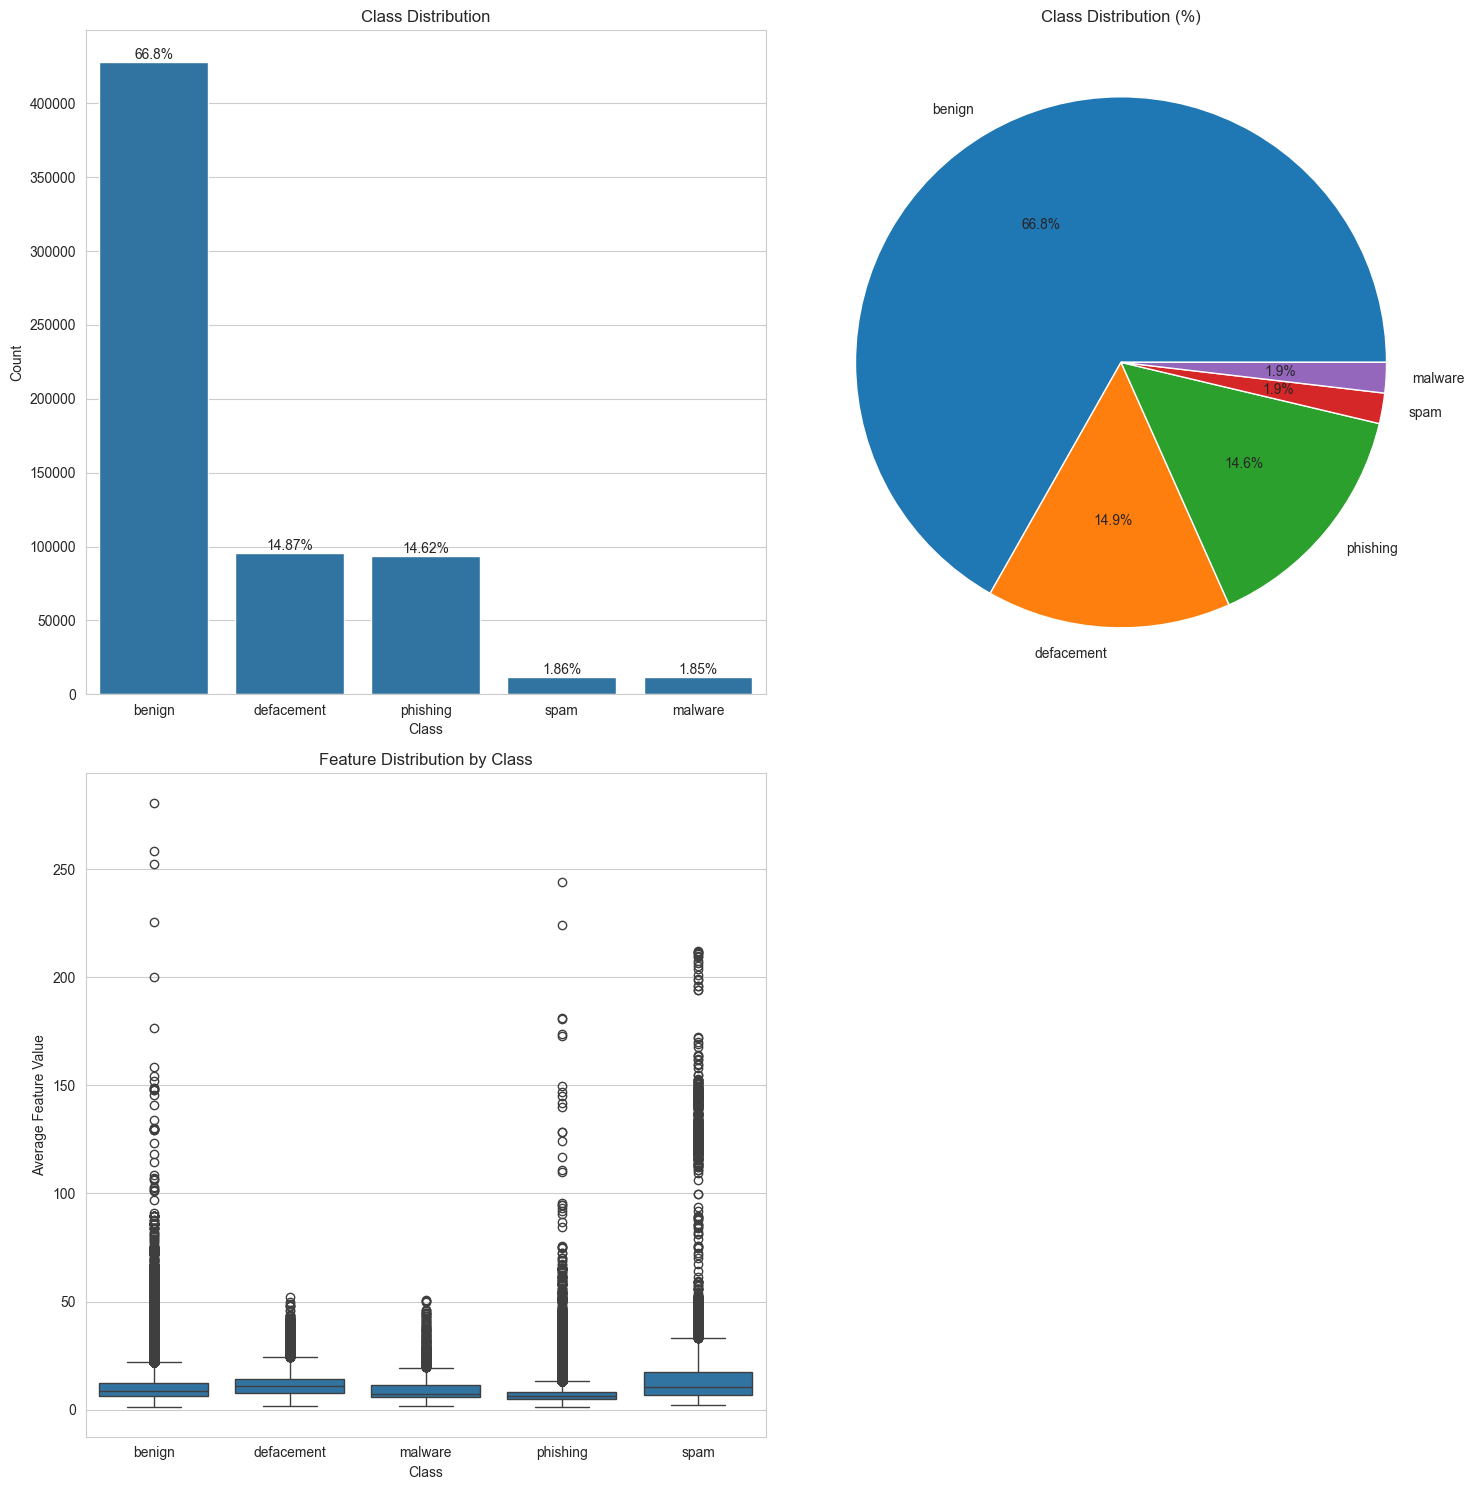

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visualization
sns.set_style('whitegrid')
plt.figure(figsize=(15, 15))

# Create subplots
plt.subplot(2, 2, 1)
class_counts = df_clean['type'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# Calculate and display class percentages
class_percentages = (class_counts / len(df_clean) * 100).round(2)
for i, (count, percentage) in enumerate(zip(class_counts, class_percentages)):
    plt.text(i, count, f'{percentage}%', ha='center', va='bottom')

# Pie chart
plt.subplot(2, 2, 2)
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%')
plt.title('Class Distribution (%)')



# Ensure you're selecting numeric columns only
numeric_columns = df_clean.select_dtypes(include=['number']).iloc[:, :79]

# Calculate the mean for the selected numeric columns across rows
mean_values = numeric_columns.mean(axis=1)

# Box plot for feature distributions by class
plt.subplot(2, 2, 3)
sns.boxplot(x='type', y=mean_values, data=df_clean)
plt.title('Feature Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Average Feature Value')
plt.xticks(rotation=0)



plt.tight_layout()
plt.show()
plt.savefig('class_balance.png')
plt.close()

In [40]:
# Print detailed statistics
print("\nClass Distribution:")
print(class_counts)
print("\nClass Percentages:")
print(class_percentages)

# Calculate and print class balance metrics
total_samples = len(df_clean)
max_class_size = class_counts.max()
min_class_size = class_counts.min()
balance_ratio = (min_class_size / max_class_size * 100).round(2)

print(f"\nClass Balance Metrics:")
print(f"Total samples: {total_samples}")
print(f"Largest class: {max_class_size} samples")
print(f"Smallest class: {min_class_size} samples")
print(f"Balance ratio: {balance_ratio}%")


Class Distribution:
type
benign        428047
defacement     95308
phishing       93673
spam           11888
malware        11876
Name: count, dtype: int64

Class Percentages:
type
benign        66.80
defacement    14.87
phishing      14.62
spam           1.86
malware        1.85
Name: count, dtype: float64

Class Balance Metrics:
Total samples: 640792
Largest class: 428047 samples
Smallest class: 11876 samples
Balance ratio: 2.77%


In [41]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# Assuming df_clean is your DataFrame and the target column is 'type'

# Step 1: Convert categorical target 'type' to numeric
df_clean['type'] = df_clean['type'].map({'benign': 0, 'defacement': 1, 'phishing': 2, 'spam': 3, 'malware': 4})

# Step 2: Drop the 'url' column and separate features (X) and target (y)
X = df_clean.drop(columns=['type', 'url'])  # Drop 'type' (target) and 'url' (URL column)
y = df_clean['type']  # The target column

# Step 3: Handle categorical features by encoding them
# Apply Label Encoding to all categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns

label_encoder = LabelEncoder()
for col in categorical_columns:
    X[col] = label_encoder.fit_transform(X[col].astype(str))  # Ensure all columns are string type before encoding

# Step 4: Handle missing values using SimpleImputer (if any)
imputer = SimpleImputer(strategy='most_frequent')  # You can change the strategy based on your need (e.g., 'mean', 'median')
X = imputer.fit_transform(X)

# Step 5: Check the class distribution before applying SMOTE
print("Class distribution before SMOTE: ")
print(y.value_counts())

# Step 6: Apply SMOTE to balance the classes
smote = SMOTE(sampling_strategy='auto', random_state=42)  # 'auto' means balance all classes
X_resampled, y_resampled = smote.fit_resample(X, y)

# Step 7: Check the class distribution after applying SMOTE
print("\nClass distribution after SMOTE: ")
print(y_resampled.value_counts())

# Optional: Check the shape of the resampled data
print(f"\nResampled data shape: X_resampled = {X_resampled.shape}, y_resampled = {y_resampled.shape}")


Class distribution before SMOTE: 
type
0    428047
1     95308
2     93673
3     11888
4     11876
Name: count, dtype: int64

Class distribution after SMOTE: 
type
0    428047
1    428047
4    428047
2    428047
3    428047
Name: count, dtype: int64

Resampled data shape: X_resampled = (2140235, 79), y_resampled = (2140235,)


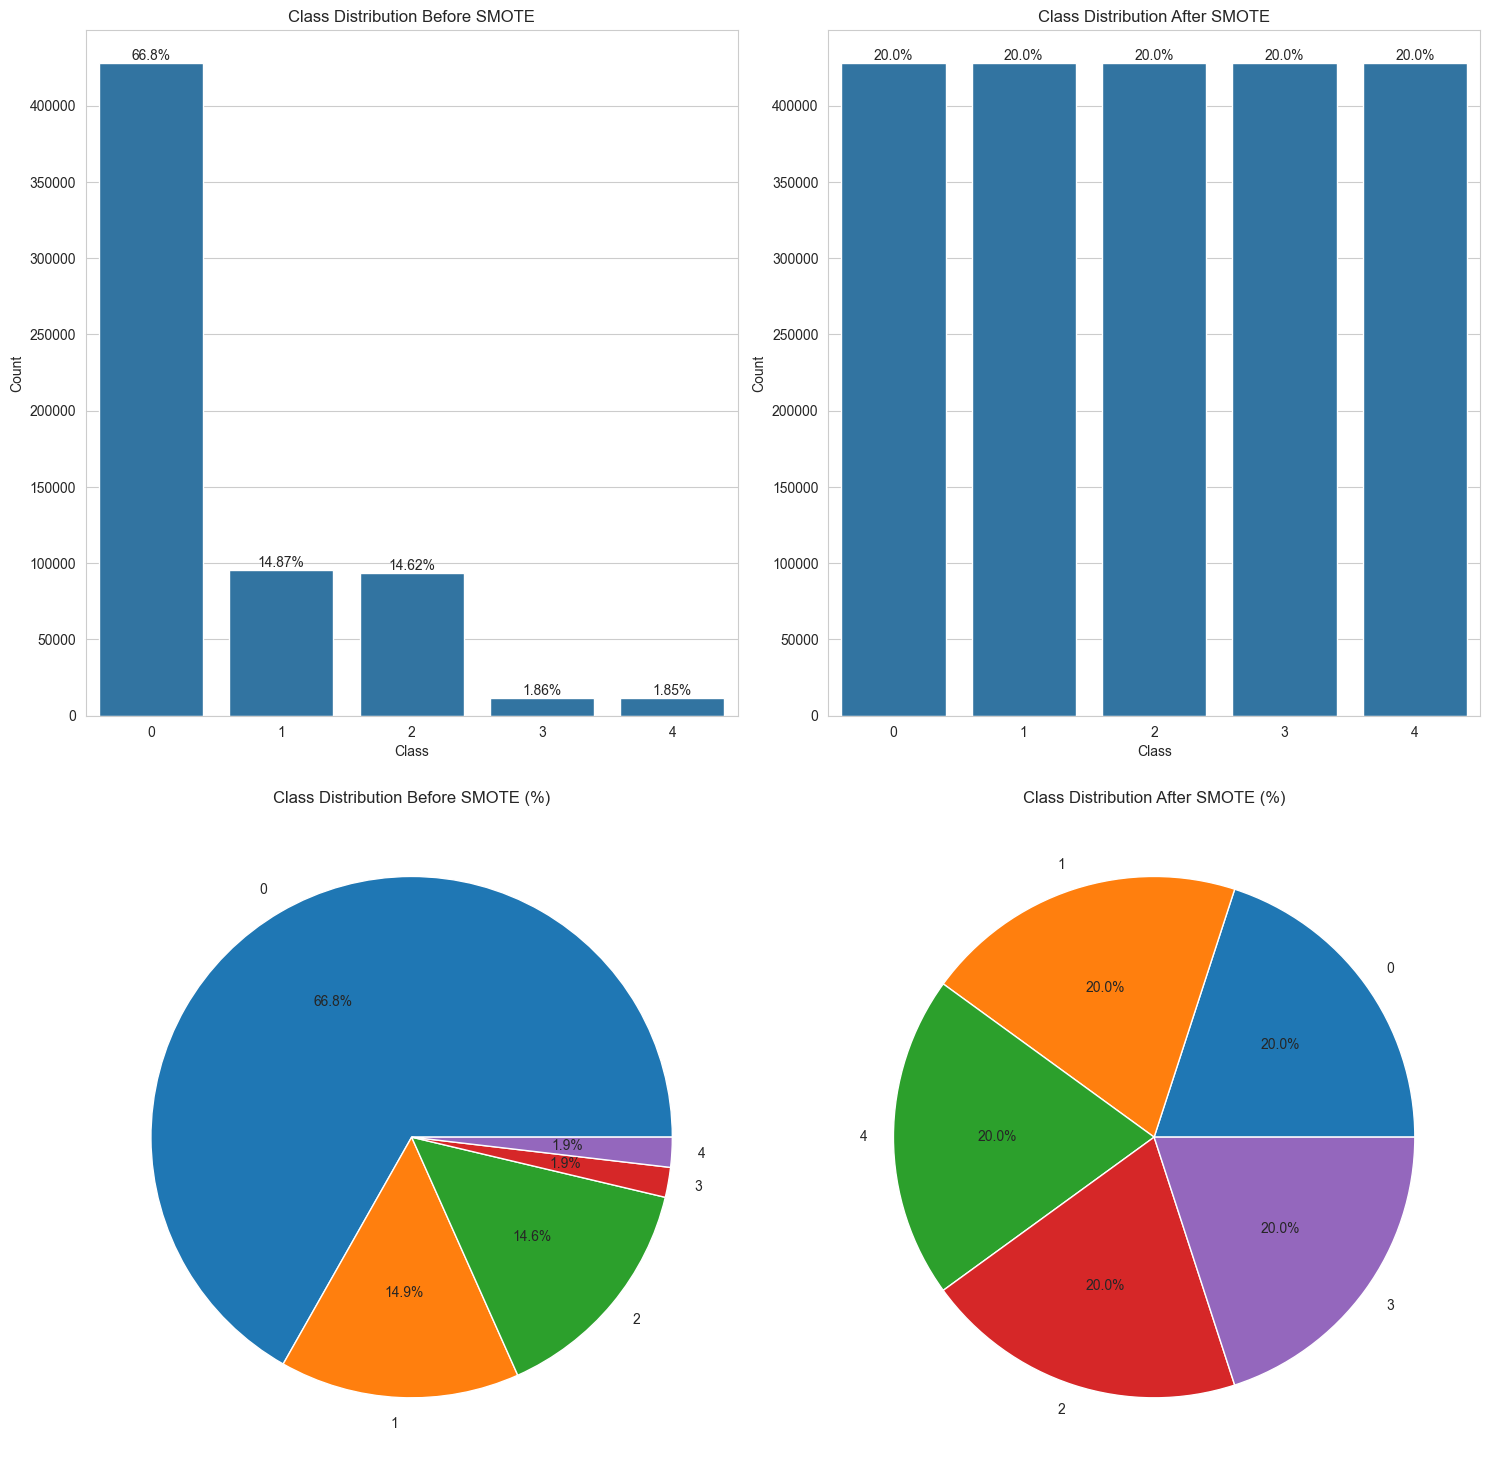

In [42]:
# columns = [
#     "Querylength", "domain_token_count", "path_token_count", "avgdomaintokenlen", "longdomaintokenlen", 
#     "avgpathtokenlen", "tld", "charcompvowels", "charcompace", "ldl_url", "ldl_domain", "ldl_path", 
#     "ldl_filename", "ldl_getArg", "dld_url", "dld_domain", "dld_path", "dld_filename", "dld_getArg", 
#     "urlLen", "domainlength", "pathLength", "subDirLen", "fileNameLen", "this.fileExtLen", "ArgLen", 
#     "pathurlRatio", "ArgUrlRatio", "argDomanRatio", "domainUrlRatio", "pathDomainRatio", "argPathRatio", 
#     "executable", "isPortEighty", "NumberofDotsinURL", "ISIpAddressInDomainName", "CharacterContinuityRate", 
#     "LongestVariableValue", "URL_DigitCount", "host_DigitCount", "Directory_DigitCount", "File_name_DigitCount", 
#     "Extension_DigitCount", "Query_DigitCount", "URL_Letter_Count", "host_letter_count", "Directory_LetterCount", 
#     "Filename_LetterCount", "Extension_LetterCount", "Query_LetterCount", "LongestPathTokenLength", 
#     "Domain_LongestWordLength", "Path_LongestWordLength", "sub-Directory_LongestWordLength", 
#     "Arguments_LongestWordLength", "URL_sensitiveWord", "URLQueries_variable", "spcharUrl", "delimeter_Domain", 
#     "delimeter_path", "delimeter_Count", "NumberRate_URL", "NumberRate_Domain", "NumberRate_DirectoryName", 
#     "NumberRate_FileName", "NumberRate_Extension", "NumberRate_AfterPath", "SymbolCount_URL", "SymbolCount_Domain", 
#     "SymbolCount_Directoryname", "SymbolCount_FileName", "SymbolCount_Extension", "SymbolCount_Afterpath", 
#     "Entropy_URL", "Entropy_Domain", "Entropy_DirectoryName", "Entropy_Filename", "Entropy_Extension", 
#     "Entropy_Afterpath"
# ]

# Step 1: Combine X_resampled and y_resampled into a new DataFrame (balanced_df)
X_resampled_df = pd.DataFrame(X_resampled, columns=feature_columns)
balanced_df = X_resampled_df.copy()
balanced_df['type'] = y_resampled

# Step 2: Set style for better visualization
sns.set_style('whitegrid')
plt.figure(figsize=(15, 15))

# Step 3: Create subplots
# Plot 1: Class Distribution Before SMOTE (using original df_clean)
plt.subplot(2, 2, 1)
class_counts = df_clean['type'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')

# Calculate and display class percentages before SMOTE
class_percentages = (class_counts / len(df_clean) * 100).round(2)
for i, (count, percentage) in enumerate(zip(class_counts, class_percentages)):
    plt.text(i, count, f'{percentage}%', ha='center', va='bottom')

# Plot 2: Class Distribution After SMOTE (using balanced_df)
plt.subplot(2, 2, 2)
class_counts_resampled = balanced_df['type'].value_counts()
sns.barplot(x=class_counts_resampled.index, y=class_counts_resampled.values)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')

# Calculate and display class percentages after SMOTE
class_percentages_resampled = (class_counts_resampled / len(balanced_df) * 100).round(2)
for i, (count, percentage) in enumerate(zip(class_counts_resampled, class_percentages_resampled)):
    plt.text(i, count, f'{percentage}%', ha='center', va='bottom')

# Plot 3: Pie chart showing class distribution before SMOTE
plt.subplot(2, 2, 3)
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%')
plt.title('Class Distribution Before SMOTE (%)')

# Plot 4: Pie chart showing class distribution after SMOTE
plt.subplot(2, 2, 4)
plt.pie(class_counts_resampled, labels=class_counts_resampled.index, autopct='%1.1f%%')
plt.title('Class Distribution After SMOTE (%)')

# Step 4: Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Save the plot as an image
plt.savefig('class_balance.png')
plt.close()


## Phase 2: Exploratory Data Analysis (EDA)

### Visualize URL distributions, token lengths, and special characters.

### Generate at least five meaningful graphs to highlight patterns.

### Identify relationships between URL structure and malicious behavior.

## Phase 3: Feature Engineering

### Extract structural features (length, subdomains, special characters).

### Use TF-IDF, Word2Vec, or Transformers for NLP-based embeddings.

### Consider character-level models for sequence-based feature extraction.

## Phase 4: Model Training

### Train 3 Traditional ML models (Random Forest, SVM, XGBoost).

### Train Deep Learning models (LSTM, CNN) for sequence-based classification.

### Fine-tune BERT/GPT to capture deeper URL semantics.

### Compare model performance with confusion matrices & ROC curves.